# Batched Graph Classification with DGL

Graph classification is an important problem with applications across many fields – bioinformatics, chemoinformatics, social network analysis, urban computing and cyber-security. Applying graph neural networks to this problem has been a popular approach recently ( Ying et al., 2018, Cangea et al., 2018, Knyazev et al., 2018, Bianchi et al., 2019, Liao et al., 2019, Gao et al., 2019).


### This tutorial demonstrates:

- batching multiple graphs of variable size and shape with DGL
- training a graph neural network for a simple graph classification task


## Simple Graph Classification Task

In this tutorial, we will learn how to perform batched graph classification with dgl via a toy example of classifying 8 types of regular graphs as below:

![](img/SimpleGraphClassificationTask.png)

We implement a synthetic dataset data.MiniGCDataset in DGL. The dataset has 8 different types of graphs and each class has the same number of graph samples.
我们在DGL中实现了一个合成数据集data.MiniGCDataset。 数据集有8种不同类型的图形，每个类具有相同数量的图形样本。

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

<Figure size 640x480 with 1 Axes>

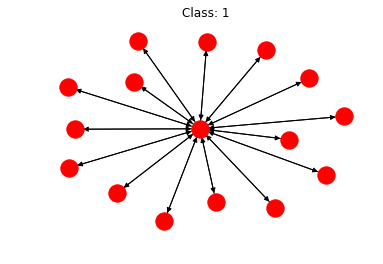

In [2]:
graph, label = dataset[10]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

## Form a graph mini-batch

To train neural networks more efficiently, a common practice is to batch multiple samples together to form a mini-batch. 为了更有效地训练神经网络，通常的做法是将多个样本一起批处理以形成小批量。

Batching fixed-shaped tensor inputs is quite easy (for example, batching two images of size 28×28 gives a tensor of shape 2×28×28). 批量固定形状的张量输入非常容易（例如，批量处理两个尺寸为28×28的图像会产生2×28×28的张量）。

By contrast, batching graph inputs has two challenges:

- Graphs are sparse.
- Graphs can have various length (e.g. number of nodes and edges).

To address this, DGL provides a dgl.batch() API. 

It leverages the trick that a batch of graphs can be viewed as a large graph that have many disjoint connected components. 它利用了一批图表可以被视为具有许多不相交的连接组件的大图形的技巧。

Below is a visualization that gives the general idea:

![](img/batch.png)

We define the following collate function to form a mini-batch from a given list of graph and label pairs.

In [3]:
import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of dgl.batch() is still a graph (similar to the fact that a batch of tensors is still a tensor). This means that any code that works for one graph immediately works for a batch of graphs. More importantly, since DGL processes messages on all nodes and edges in parallel, this greatly improves efficiency.

## Graph Classifier

The graph classification can be proceeded as follows:

![](img/GraphClassifier.png)

From a batch of graphs, we first perform message passing/graph convolution for nodes to “communicate” with others. After message passing, we compute a tensor for graph representation from node (and edge) attributes. This step may be called “readout/aggregation” interchangeably. Finally, the graph representations can be fed into a classifier g to predict the graph labels.
从一批图中，我们首先对节点执行消息传递/图卷积以与其他节点“通信”。在消息传递之后，我们从节点（和边缘）属性计算图表示的张量。该步骤可以互换地称为“读出/聚合”。最后，可以将图表示馈入分类器g以预测图标签。


## Graph Convolution

Our graph convolution operation is basically the same as that for GCN (checkout our tutorial). The only difference is that we replace 

$h_{v}^{(l+1)}=\operatorname{ReLU}\left(b^{(l)}+\sum_{u \in \mathcal{N}(v)} h_{u}^{(l)} W^{(l)}\right)$ by
$h_{v}^{(l+1)}=\operatorname{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|} \sum_{u \in \mathcal{N}(v)} h_{u}^{(l)} W^{(l)}\right)$

The replacement of summation by average is to balance nodes with different degrees, which gives a better performance for this experiment.

Note that the self edges added in the dataset initialization allows us to include the original node feature $h_{v}^{(l)}$ when taking the average.

In [4]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

## Readout and Classification

For this demonstration, we consider initial node features to be their degrees. After two rounds of graph convolution, we perform a graph readout by averaging over all node features for each graph in the batch

$h_{g}=\frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} h_{v}$

In DGL, dgl.mean_nodes() handles this task for a batch of graphs with variable size. We then feed our graph representations into a classifier with one linear layer to obtain pre-softmax logits.

In [5]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

## Setup and Training

We create a synthetic dataset of 400 graphs with 10 ~ 20 nodes. 320 graphs constitute a training set and 80 graphs constitute a test set.

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

D:\progrom\python\python\python3\lib\site-packages\dgl\base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, loss 2.1045
Epoch 1, loss 1.9521
Epoch 2, loss 1.8407
Epoch 3, loss 1.7947
Epoch 4, loss 1.6927


KeyboardInterrupt: 

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [ ]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))